# Wire Cutting Phrased as a Two-Qubit `Move` Instruction

In this tutorial, we will reconstruct expectation values of a seven-qubit circuit by splitting it into two four-qubit circuits using wire cutting.

Like any circuit knitting technique, wire cutting can be described as three consecutive steps:

- **cut** some wires in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments on the backend(s)
- **reconstruct** the expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting.cutting.instructions import Move
from circuit_knitting.cutting import (
    partition_problem,
    reconstruct_expectation_values,
)

### Create a circuit to cut

First, we begin with a circuit inspired by Fig. 1(a) of [arXiv:2302.03366v1](https://arxiv.org/abs/2302.03366v1).

In [2]:
qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

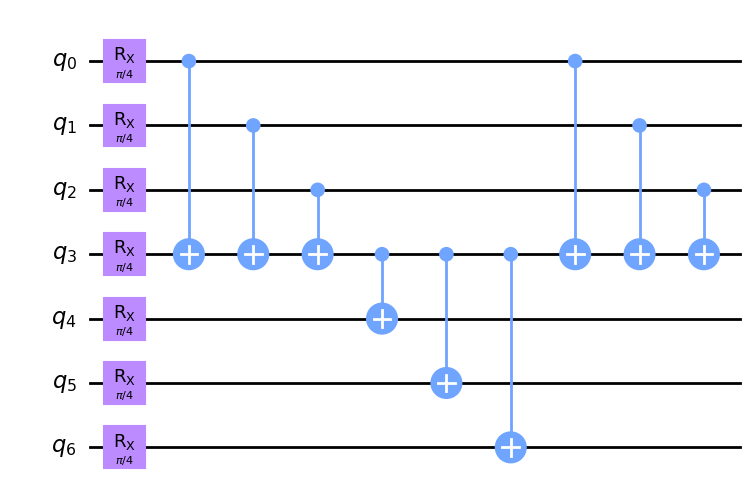

In [3]:
qc_0.draw("mpl")

### Specify some observables

Next, we specify a list of observables whose expectation values we would like to determine.

In [4]:
observables_0 = PauliList(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

### Create a new circuit where `Move` instructions have been placed at the desired cut locations

Given the above circuit, we would like to place two wire cuts on the middle qubit line, so that the circuit can separate into two circuits of four qubits each.  One way to do this (currently, the only way) is to place two-qubit `Move` instructions that move the state from one qubit wire to another.  A `Move` instruction is conceptually equivalent to a reset operation on the second qubit, followed by a SWAP gate.  The effect of this instruction is to transfer the state of the first (source) qubit to the second (detination) qubit, while discarding the incoming state of the second qubit.  For this to work as intended, it is important that the second (destination) qubit share no entanglement with the remainder of the system; otherwise, the reset operation will cause the state of the remainder of the system to be partially collapsed.

Here, we build a new circuit with one additional qubit and the `Move` operations in place.  In this example, we are able to reuse a qubit: the source qubit of the first `Move` becomes the destination qubit of the second `Move` operation.

In [ ]:
qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

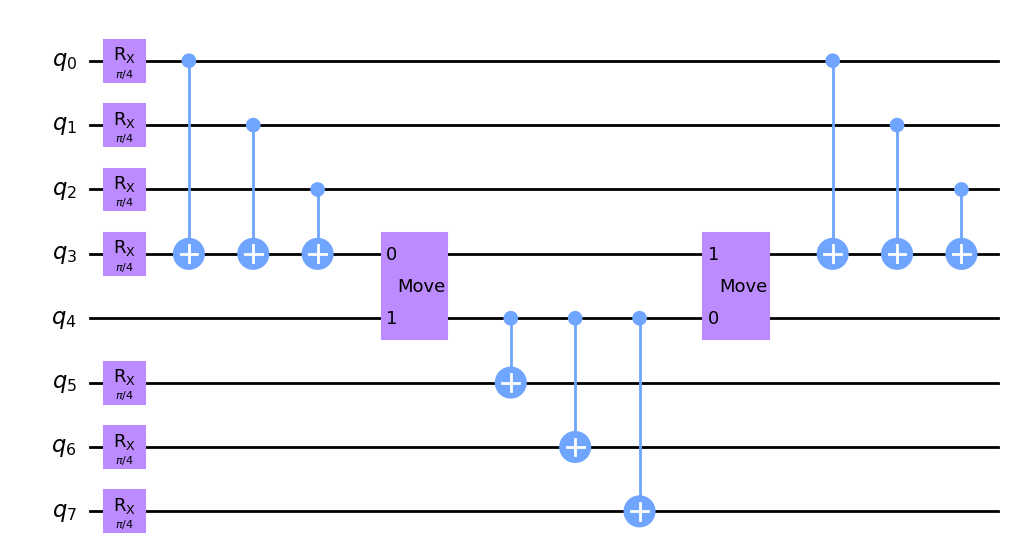

In [6]:
qc_1.draw("mpl")

### Create observables to go with the new circuit

These observables correspond with `observables_0`, but we must account correctly for the extra qubit wire that has been added (i.e., we insert an "I" at index 4).  Note that in Qiskit, the string representation qubit-0 corresponds to the right-most Pauli character.

In [7]:
observables_1 = PauliList(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

### Separate the circuit and observables

As in the previous tutorials, qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [8]:
partitioned_problem = partition_problem(
    circuit=qc_1, partition_labels="AAAABBBB", num_samples=np.inf, observables=observables_1
)

`partition_problem` returns:

- `Dict` mapping partition labels to subcircuits
- `Dict` mapping partition labels to subobservables
- A `list` of  ``QPDBasis`` instances, one for each decomposed instruction

### Visualize the decomposed problem

In [9]:
partitioned_problem.subobservables

{'A': PauliList(['IIII', 'ZIII', 'IIIZ']),
 'B': PauliList(['ZIII', 'IIII', 'IIII'])}

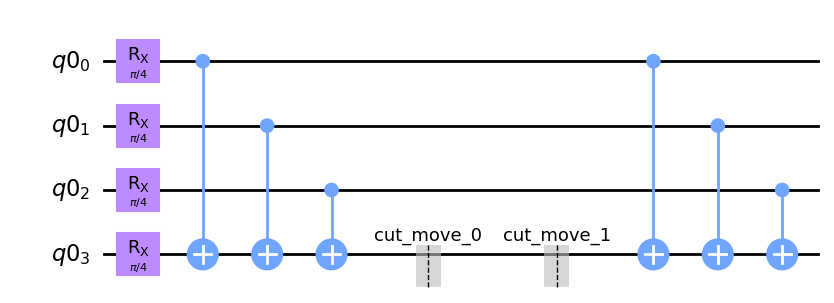

In [10]:
partitioned_problem.subcircuits["A"].draw("mpl")

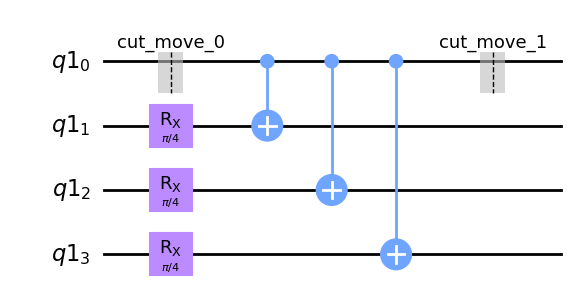

In [11]:
partitioned_problem.subcircuits["B"].draw("mpl")

### Calculate the sampling overhead for the chosen cuts

The sampling overhead is the factor by which the number of samples must increase for the quasiprobability decomposition to result in the same amount of error, $\epsilon$, as one would get by sampling the original circuit. Cutting wires with local operations (LO) only incurs a sampling overhead of $4^{2k}$, where $k$ is the number of cuts [[Brenner, Piveteau, Sutter]](https://arxiv.org/abs/2302.03366).

Here we cut two wires, resulting in a sampling overhead of $4^4$.

In [12]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}")

Sampling overhead: 256.0


In [13]:
# Set up Qiskit Aer Sampler primitives.
sampler_a = Sampler(run_options={"shots": 2**12})
sampler_b = Sampler(run_options={"shots": 2**12})

# Retrieve the quasi-probability distributions for each subexperiment
quasi_dists_a = (
    sampler_a.run(partitioned_problem.subexperiments["A"]).result().quasi_dists
)
quasi_dists_b = (
    sampler_b.run(partitioned_problem.subexperiments["B"]).result().quasi_dists
)

`execute_experiments` returns:

- A 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment
- The coefficients for each subexperiment

### Reconstruct the expectation values

`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape (`num_unique_samples`, `num_partitions`, `num_commuting_observ_groups`), and `coefficients` is a list with length equal to the number of unique samples. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s), as output from `decompose_problem` above.

In [14]:
quasi_dists = {"A": quasi_dists_a, "B": quasi_dists_b}
reconstructed_expvals = reconstruct_expectation_values(
    partitioned_problem.subexperiments,
    partitioned_problem.subobservables,
    partitioned_problem.weights,
    quasi_dists,
)

### Compare the reconstructed expectation values with the exact expectation values from the original circuit

In [15]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([qc_0] * len(observables_0), list(observables_0)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [0.17243379, 0.70595753, 0.68579]
Exact expectation values: [0.1767767, 0.70710678, 0.70710678]
Errors in estimation: [-0.0043429, -0.00114925, -0.02131678]
Relative errors in estimation: [-0.02456716, -0.00162528, -0.03014648]


In [16]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table